Домашнее задание 1

Колесов Александр 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import pickle

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

In [153]:
def get_cross_entropy_loss(model, x):
  probability_x = model(x)
  return -1*torch.sum(torch.log(probability_x))


def train_epoch(model, train_loader, optimizer, use_cuda):
  model.train()
  
  train_losses = []
  for x in train_loader:
    if use_cuda:  
      x = x.cuda()
    loss = get_cross_entropy_loss(model, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses


def eval_model(model, data_loader, use_cuda):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      if use_cuda:
        x = x.cuda()
      loss = get_cross_entropy_loss(model, x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)
  return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, use_cuda=False):
  if use_cuda:
    model = model.cuda()
  optimizer = optim.SGD(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_model(model, test_loader, use_cuda)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train_epoch(model, train_loader, optimizer, use_cuda))
    test_loss = eval_model(model, test_loader, use_cuda)
    test_losses.append(test_loss)

  return train_losses, test_losses

In [154]:
def generate_1d_data(count, bins):
  np.random.seed(42)
  a = 0.2 + 0.05 * np.random.randn(count)
  b = 0.6 + 0.15 * np.random.randn(count)
  mask = np.random.rand(count) < 0.5
  samples = (a * mask + b * (1 - mask)) * (bins - 1)
  data = np.clip(samples.astype('int'), 0.0, (bins - 1))
  split = int(0.8 * count)
  train_data, test_data = data[:split], data[split:]
  return train_data, test_data

def plot_1d_data(train_data, test_data):
  bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.set_title('train')
  ax1.hist(train_data, bins=bins, density=True)
  ax1.set_xlabel('x')
  ax2.set_title('test')
  ax2.hist(test_data, bins=np.arange(bins), density=True)
  plt.show()

def plot_training_curves(train_losses, test_losses):
  plt.figure(figsize=(8, 6))
  n_epochs = len(test_losses) - 1
  x_train = np.linspace(0, n_epochs, len(train_losses))
  x_test = np.arange(n_epochs + 1)

  plt.plot(x_train, train_losses, label='train loss')
  plt.plot(x_test, test_losses, label='test loss')
  plt.legend()
  plt.title('training curves')
  plt.xlabel('Epoch')
  plt.ylabel('NLL')

def plot_1d_distribution(data, distribution):
  size = len(distribution)

  plt.figure(figsize=(8, 6))
  plt.hist(data, bins=np.arange(size) - 0.5, label='train data', density=True)

  x = np.linspace(-0.5, size - 0.5, 1000)
  y = distribution.repeat(1000 // size)
  plt.plot(x, y, label='learned distribution')

  plt.title('learned distribution')
  plt.xlabel('x')
  plt.ylabel('Probability')
  plt.legend() 

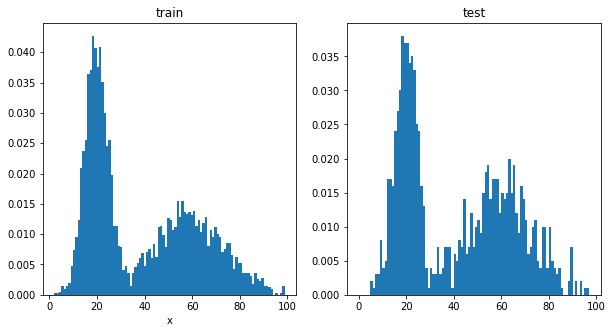

In [155]:
BINS = 100
COUNT = 5000

train_data, test_data = generate_1d_data(COUNT, BINS)
plot_1d_data(train_data, test_data)

In [169]:
class SoftmaxModel(nn.Module):
  def __init__(self, bins):
    super().__init__()
    self.bins = bins
    self.logits = nn.Parameter(torch.zeros(bins))

  def forward(self, x):
    probs = torch.nn.functional.softmax(self.logits)
    return probs[x.long()]

In [167]:
def get_distribution(model):
  model.eval()
  with torch.no_grad():
    return torch.nn.functional.softmax(model.logits)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


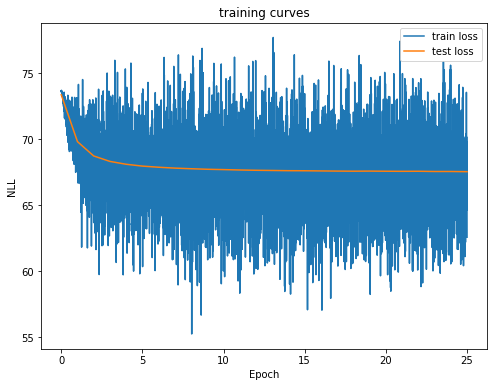

In [181]:
# you have to choose these parameters by yourself
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-2
USE_CUDA = False

model = SoftmaxModel(BINS)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)
#distribution = get_distribution(model)

plot_training_curves(train_losses, test_losses)
#plot_1d_distribution(train_data, distribution)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


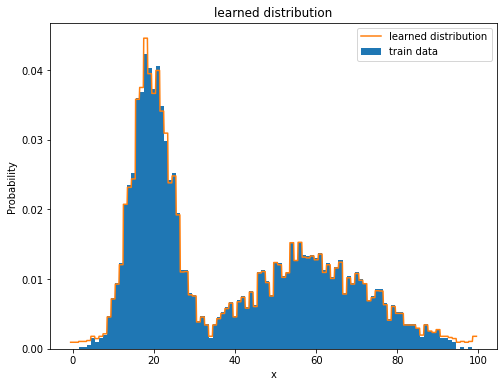

In [171]:
distribution = get_distribution(model).numpy()
plot_1d_distribution(train_data, distribution)

TASK 2


В данной задаче наш автоэнкодер будет принимать 2 точки, каждую из которых мы при помощи one_hot_encoding в вектор из 60 элементов, состоящий из 0 и 1, после этого склеив эти 2 вектора ,мы получаем вектор из 120 элементов. Данный вектор мы и будем подавать в автоэнкодер. Поскольку у нас автоэнкодер вернет тоже вектор из 120 элементов, то на выходе мы получаем какой-то 120-й элементный вектор. В классе MADE, мы в реализации учтем тот момент что величина m[idx] (номер максимального элемента с предыдущего слоя, который связан с данной вершиной в текущем слое) будет в прямом порядке от 0 до 119 как на входе, так и на выходе. Таким образом, данный выходной вектор, тоже будет представлять собой вектор из  двух вектора по 60 элементов, где первый это какой-то образ первой координаты, а второй вектор какой-то образ второй координаты. Поскольку нам нужна вероятность, то каждый из таких векторов мы прогоним через Softmax, и оба их склеим. Опять получим вектор из 120 элементов , где каждое значение от 0 до 1. И для того, чтобы определить вероятность данной пары мы воспользуемся следующей формулой из статьи:

Пусть $x$ - входной вектор, $\hat{x}$ -выходной вектор

$$-\log{p(x)} = \sum_{d = 1}^{D} -x_{d}\log{p}(x_{d} = 1| x_{<d}) - (1 - x_{d})\log{p}(x_{d} = 0| x_{<d}) = \mathcal{l}(x) $$
$$ \mathcal{l}(x) = \sum_{d = 1}^{D} -x_{d}\log{\hat{x}_{d}} - (1-x_{d})\log(1 - \hat{x}_{d}) $$
Таким образом, мы можем находить вероятность каждой пары

In [14]:
from tqdm import tqdm_notebook
from torch.autograd import Variable

Посмотрим изображение, предложенное нам

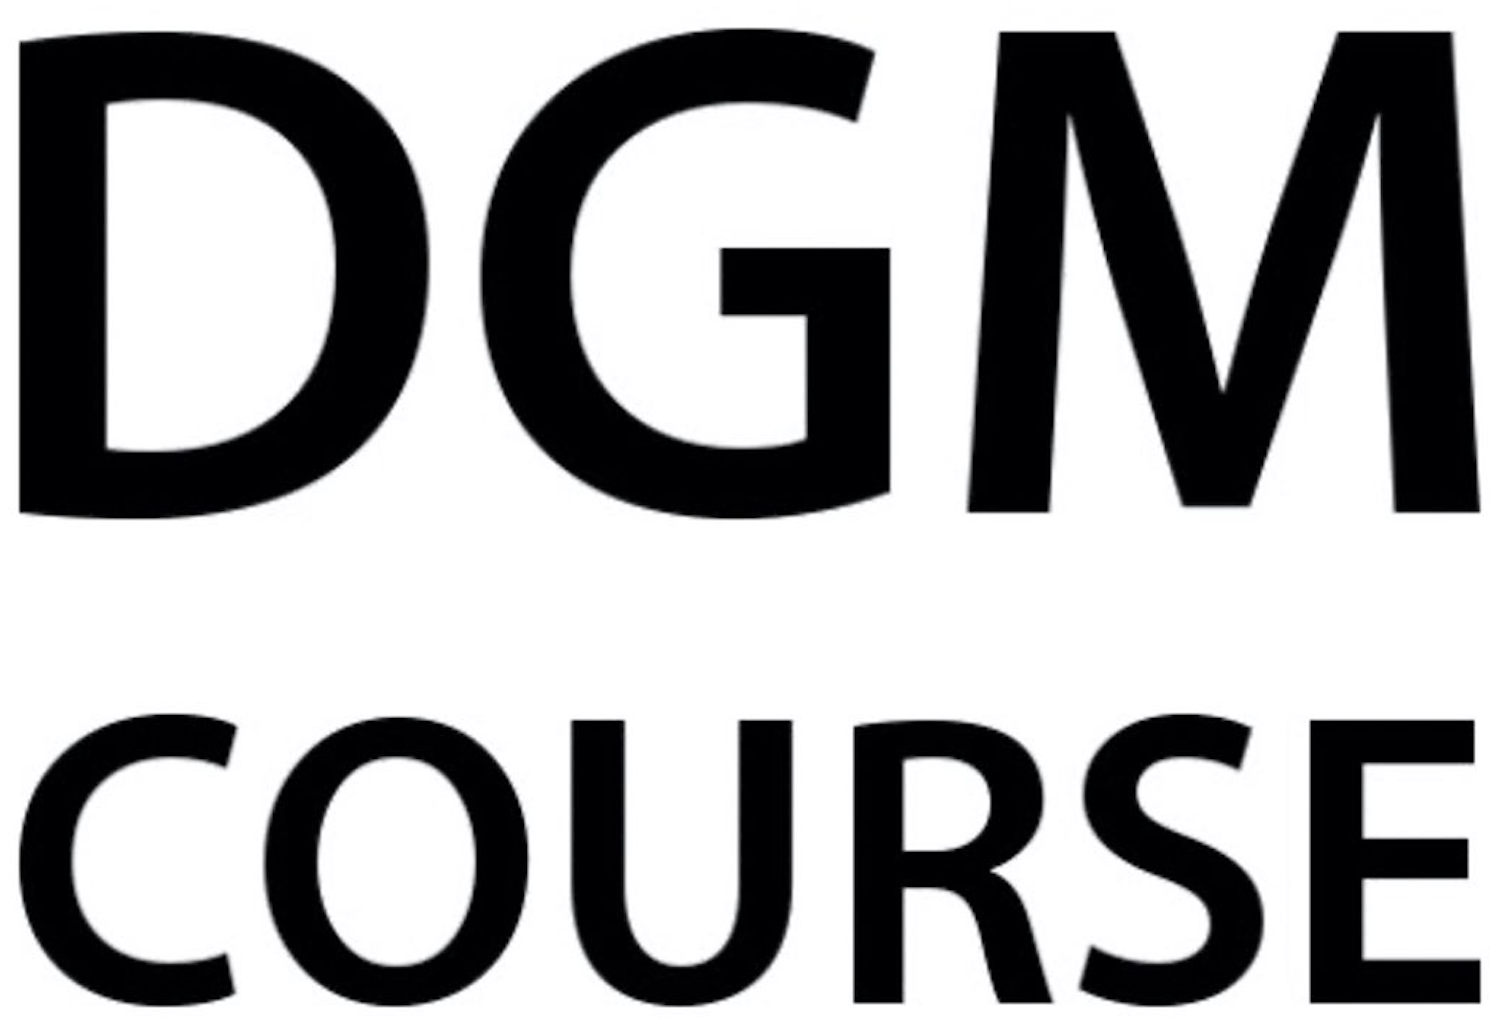

In [35]:
im  = Image.open('dgm.png')
im

In [1]:
def generate_2d_data(count, bins):
  im = Image.open('dgm.png').resize((bins, bins)).convert('L')
  im = np.array(im).astype('float32')
  dist = im / im.sum()

  pairs = list(itertools.product(range(bins), range(bins)))
  idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
  samples = np.array([pairs[i] for i in idxs])

  split = int(0.8 * len(samples))
  return dist, samples[:split], samples[split:] # random pairs

In [2]:
def plot_2d_data(train_data, test_data):
  bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
  train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
  
  for i in range(len(train_data)):
      train_dist[train_data[i][0], train_data[i][1]] += 1
  train_dist /= train_dist.sum() ## 255

  for i in range(len(test_data)):
      test_dist[test_data[i][0], test_data[i][1]] += 1
  test_dist /= test_dist.sum() ## 255


  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
  ax1.set_title('Train Data')
  ax1.imshow(train_dist, cmap='gray')
  ax1.axis('off')
  ax1.set_xlabel('x1')
  ax1.set_ylabel('x0')

  ax2.set_title('Test Data')
  ax2.imshow(test_dist, cmap='gray')
  ax2.axis('off')
  ax2.set_xlabel('x1')
  ax2.set_ylabel('x0')

In [6]:
def plot_2d_distribution(true_dist, learned_dist):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
  ax1.imshow(true_dist, cmap='gray')
  ax1.set_title('True Distribution')
  ax1.axis('off')
  ax2.imshow(learned_dist, cmap='gray')
  ax2.set_title('Learned Distribution')
  ax2.axis('off')

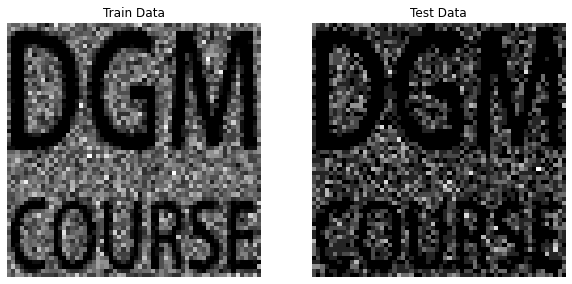

In [7]:
COUNT = 20000
BINS = 60

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data)

Посмотрим на объект, возвращаемый функцией generate_2d_data

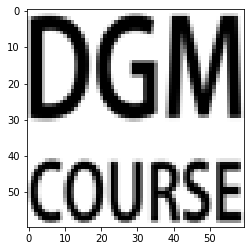

In [8]:
plt.imshow(image,cmap='gray')

In [9]:
class MaskedLinear(nn.Linear):
  """ same as Linear except has a configurable mask on the weights """
  def __init__(self,in_features,out_features,bias = True):
    #super(MaskedLinear,self).__init__(in_features,out_features,bias)
    super().__init__(in_features,out_features,bias)
    self.register_buffer('mask', torch.ones(out_features, in_features))

  def set_mask(self,mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T)) 
  
  def forward(self,input):
    return F.linear(input, self.mask*self.weight, self.bias) # W*x + bias ; (Adamar's product)
  """
  - about register_buffer:
  we want to store torch.ones, and we don't want to make new parameter, which will store it, hence we do register_buffer
  - about copy:
  
  """

In [10]:
def to_one_hot(labels, d):
  one_hot = torch.FloatTensor(labels.shape[0], d).to(labels.device)
  one_hot.zero_()
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot

Здесь стоит отметить, что отрисовка масок происходит непосредсвтенно в функции update_mask при ее вызове

In [11]:
class MADE(nn.Module):
  def __init__(self, nin, bins,  hidden_sizes, num_masks, natural_ordering):
    """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
    """
    super().__init__()# self(MADE,self).__init__(#paramerets)
    self.nin = nin # self.fc1 = nn.Linear(nin, the_follow_dimension)
    self.hidden_sizes = hidden_sizes # a list of integers (on which layer how many nodes)
    self.bins = bins
    self.nout = 2*bins ## ?? self.nout = nin*bins
    self.ordering = np.arange(self.nin)
    self.masks = torch.zeros((self.nin,200))

    assert self.nout % self.nin == 0 , "nout must be integer multiple of nin"

    # define a simple MLP neural net
    self.net = []
    hs = [self.nin] + hidden_sizes + [self.nout] # list of sizes of each layer
    for h0,h1 in zip(hs,hs[1:]):
      self.net.extend([
                       MaskedLinear(h0,h1),
                       nn.ReLU()# F.relu()          
      ])
    self.net.pop() #pop the Last Relu for the output layer
    self.net = nn.Sequential(*self.net)



    # seeds for orders/connectivities of the model ensemble
    self.natural_ordering = natural_ordering
    self.num_masks = num_masks
    self.seed = 0 # for cycling through num_masks orderings

    self.m = {}
    #self.update_mask() # builds the initial self.m connectivity
    # note, we could also precompute the masks and cache them, but this
    # could get memory expensive for large number of masks.
    self.update_masks()

  def update_masks(self):
      
    L = len(self.hidden_sizes)

      # fetch the next seed and construct a random stream
    rng = np.random.RandomState(self.seed)
    self.seed = (self.seed + 1) % self.num_masks

      # sample the order of the inputs and the connectivity of all neurons
    self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin) 
    for l in range(L):
      self.m[l] = rng.randint(self.m[l-1].min(),self.nin -1, size = self.hidden_sizes[l])

      # construct the mask matrices
    masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
    masks.append(self.m[L-1][:,None] < self.m[-1][None,:])

      # handle the case where nout = nin * k, for integer k > 1
    if self.nout > self.nin:
      k = int(self.nout / self.nin)
        # replicate the mask across the other outputs
      masks[-1] = np.concatenate([masks[-1]]*k, axis=1)

      # set the masks in all MaskedLinear layers
    layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
    for l,m in zip(layers, masks):
      l.set_mask(m)
      plt.figure(figsize=(5,5))
      plt.imshow(m,cmap="gray")
      plt.show()

  #  отрисовка масок происходит в функции update_mask()
  def visualize_masks(self):
    for m in masks:
      print(m.shape,type(m))
      plt.figure(figsize=(5, 5))
      plt.imshow(masks, cmap='gray')
      plt.show()

  def forward(self,x):
    return self.net(x)


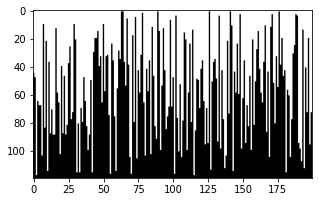

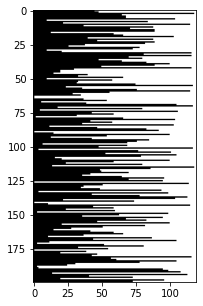

In [88]:
model = MADE(120, 60, [200], num_masks=1,natural_ordering=True)

In [89]:
model.train()

MADE(
  (net): Sequential(
    (0): MaskedLinear(in_features=120, out_features=200, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=200, out_features=120, bias=True)
  )
)

Отрисовка функции потерь, будет происходить ниже при вычислении градиентов

По проведенным исследованиям при различных размерах батча и различных лернинг рейтах, было увидено, что  для поулчения наиболее близкого распределения надо использовать небольшой размер батча. Так, напрмер, лучше всех себя продемонстрировал bathc_size =2 б leraning_reat = 1e-2 и   в качестве количества эпох было взято 6 эпох.

In [90]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False)
#train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, use_cuda=USE_CUDA)

In [39]:
im = im.resize((60,60)).convert('L')
im = np.array(im).astype('float32')
dist = im/im.sum()

In [91]:
from torch.autograd import Variable
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2)
losses = []

for epoch in range(9):
  for data in tqdm_notebook(train_loader):

    target_train = []
    for element in data:
      target_train.append(10000*dist[element[0]][element[1]])
    target_train = torch.tensor(target_train)

    
    for idx,batch in enumerate(data):
      x = batch
      x = to_one_hot(x,60)
      x = torch.cat([x[0],x[1]],dim=0)
      x = np.array(x,dtype="float32")
      x = Variable(torch.from_numpy(x), requires_grad=True)
      optimizer.zero_grad()
      xtr = model(x)

      xt1,xt2 = F.softmax(xtr[:60],dim=0),F.softmax(xtr[60:],dim=0)
      prob = torch.cat([xt1,xt2],dim=0)
      one = to_one_hot(batch,60)
      one = torch.cat((one[0],one[1]),dim =0)
      xtrhat = 10000*torch.exp(-1*torch.sum(-one*torch.log(prob)  - (1 - one)*torch.log(1 - prob)))
      xtrhat = xtrhat.reshape(-1)
      if idx == 0:
        xtrha = xtrhat
      else:
        xtrha = torch.cat((xtrha,xtrhat),dim = 0)
     
    
    loss = torch.nn.functional.mse_loss((xtrha.reshape(-1,1)).double(), target_train.reshape(-1,1))
    losses.append(loss.cpu().data.item())
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Как и ожилается за счет маленького размера батча, у нас будет большая дисперсия у стох градиента, но несмотря на это лосс заметно снижается на трейне

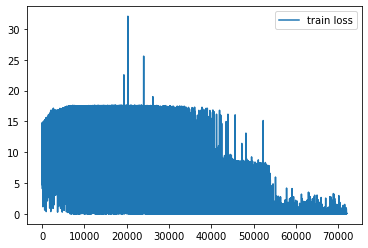

In [92]:
plt.plot(losses,label="train loss")
plt.legend()
plt.show()

Следующий код продемонстрирует построения вероятности в каждом из 3600 пикселей нашей картинки и построит искомую веротяность(то есть и картинку)

In [93]:
model.eval()
current = [[0.0]*60 for i in range(60)]
with torch.no_grad():
  for i in range(60):
    for j in range(60):
      x = torch.tensor([i,j])
      x = to_one_hot(x,60)
      x = torch.cat([x[0],x[1]],dim=0)
      x = np.array(x,dtype="float32")
      x = Variable(torch.from_numpy(x))
      xtr = model(x)

      xt1,xt2 = F.softmax(xtr[:60],dim=0),F.softmax(xtr[60:],dim=0)
      prob = torch.cat([xt1,xt2],dim=0)
      one = to_one_hot(torch.tensor([i,j]),60)
      one = torch.cat((one[0],one[1]),dim =0)
      xtrhat = torch.exp(-1*torch.sum(-one*torch.log(prob)  - (1 - one)*torch.log(1 - prob))).item()
      current[i][j] = xtrhat

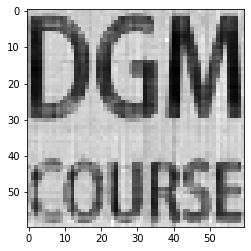

In [94]:
inter_ = torch.tensor(current)
plt.imshow(inter_, cmap="gray") # inter

Также можно посчитать валидационный лосс на тестовой выборке

In [96]:
model.eval()
total_loss = 0
with torch.no_grad():
  for data in tqdm_notebook(test_loader):

    target_train = []
    for element in data:
      target_train.append(10000*dist[element[0]][element[1]])
    target_train = torch.tensor(target_train)

    
    for idx,batch in enumerate(data):
      x = batch
      x = to_one_hot(x,60)
      x = torch.cat([x[0],x[1]],dim=0)
      x = np.array(x,dtype="float32")
      x = Variable(torch.from_numpy(x), requires_grad=True)
      xtr = model(x)

      xt1,xt2 = F.softmax(xtr[:60],dim=0),F.softmax(xtr[60:],dim=0)
      prob = torch.cat([xt1,xt2],dim=0)
      one = to_one_hot(batch,60)
      one = torch.cat((one[0],one[1]),dim =0)
      xtrhat = 10000*torch.exp(-1*torch.sum(-one*torch.log(prob)  - (1 - one)*torch.log(1 - prob)))
      xtrhat = xtrhat.reshape(-1)
      if idx == 0:
        xtrha = xtrhat
      else:
        xtrha = torch.cat((xtrha,xtrhat),dim = 0)

     
    
    loss = torch.nn.functional.mse_loss((xtrha.reshape(-1,1)).double(), target_train.reshape(-1,1))
    total_loss+=loss*x.shape[0]
    avg_loss = total_loss/len(test_loader)
print(avg_loss.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



8.095108732238499
